### PCA

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.decomposition import PCA, SparsePCA
from sklearn.covariance import empirical_covariance

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches

import seaborn as sns
import joblib
import os

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning) # setting ignore as a parameter and further adding category

In [2]:
rng = 42

In [3]:
p = '../data/'
input_name = 'cleaned.csv'

df = pd.read_csv(f'{p}{input_name}')

In [4]:
# set up folder to save results
#os.makedirs('export_run5_PCA')
prefix = 'export_run5_PCA/export'

In [5]:
def df_filtering(df, i_e = 'I', f_cols = []):

    filtered_df = df[df.i_e == i_e]
    filtered_df = filtered_df[f_cols+['act']]
    
    return filtered_df

def data_split(df):
    X, y = df.iloc[:,:-1], df.iloc[:,-1:]
    y = np.where(y['act']=='R',1,0)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rng, stratify=y) 
    
    return X_train, X_test, y_train, y_test

In [6]:
non_feature_cols = ['control_number', 'disp_date', 'i_e', 'ship_date', 
                    'disp_date_yyyy', 'disp_date_mm', 'disp_ship_date']

target = ['act', 'dp_cd']

feature_cols = ['species_code', 'wildlf_desc', 'specific_generic_name', 'genus', 'species', 'wildlf_cat', 
                'ctry_org', 'ctry_ie','purp', 'src', 'trans_mode', 'pt_cd',
                 'qty', 'unit', #'cartons',
                 'value', 'ship_date_mm']

export_df = df_filtering(df, i_e = 'E', f_cols = feature_cols)
X_train, X_test, y_train, y_test = data_split(export_df)

In [8]:
X_train.head()

,species_code,wildlf_desc,specific_generic_name,genus,species,wildlf_cat,ctry_org,ctry_ie,purp,src,trans_mode,pt_cd,qty,unit,value,ship_date_mm
65575,PINM,TRI,GREAT PEARL OYSTER,PINCTADA,MARGARITIFERA,MOL,PF,JP,T,W,A,BA,1.0,NO,0.0,5
126087,ALLM,SPE,AMERICAN ALLIGATOR,ALLIGATOR,MISSISSIPPIENSIS,REP,US,TT,M,W,A,MI,14.0,NO,2320.0,4
486033,PIMX,JWL,GOLD-LIP OYSTER,PINCTADA,MAXIMA,MOL,MX,HK,T,W,A,HA,1.0,NO,53.0,1
798703,MOLL,LIV,SHELLS MOLLUSCS,NaN_genus,NaN_species,MOL,VS,CA,T,W,A,LA,350.0,NO,208.0,12
392269,WDER,SKI,WHITE-TAILED DEER,ODOCOILEUS,VIRGINIANUS,MAM,US,CN,T,W,O,NW,744.0,NO,22190.0,2


#### Option 1: TargetEncoding on Categorical and StandardScaler on Numeric Cols

In [29]:
numerical_var = ['value', 'qty']
categorical_var = ['species_code', 'wildlf_desc', 'specific_generic_name', 'genus', 'species', 'wildlf_cat', 
                'ctry_org', 'ctry_ie','purp', 'src', 'trans_mode', 'pt_cd', 'unit']

ct_target = make_column_transformer(
    (RobustScaler(), numerical_var),
    (TargetEncoder(), categorical_var),
    remainder='passthrough')

In [30]:
X_train_t = ct_target.fit_transform(X_train, y_train)
X_test_t = ct_target.transform(X_test)

In [31]:
X_train_t[:2]

array([[-1.06467927e-01, -9.18367347e-02,  1.17187500e-03,
         1.41166405e-02,  1.17187500e-03,  3.24858757e-03,
         1.04239055e-03,  4.55603725e-03,  0.00000000e+00,
         6.34431783e-03,  8.38549976e-03,  7.48914176e-03,
         5.48979767e-03,  3.54484225e-04,  8.36848617e-03,
         5.00000000e+00],
       [ 5.11046047e-01,  4.08163265e-02,  5.99026582e-03,
         3.08513794e-03,  5.99026582e-03,  5.99026582e-03,
         5.99026582e-03,  9.32896890e-03,  7.68923905e-03,
         9.43396226e-03,  3.24745616e-03,  7.48914176e-03,
         5.48979767e-03,  5.40807723e-03,  8.36848617e-03,
         4.00000000e+00]])

#### Option 2: TargetEncoding on Categorical and RobustScaler on all

In [35]:
numerical_var = ['value', 'qty']
categorical_var = ['species_code', 'wildlf_desc', 'specific_generic_name', 'genus', 'species', 'wildlf_cat', 
                'ctry_org', 'ctry_ie','purp', 'src', 'trans_mode', 'pt_cd', 'unit']


ct_target = make_column_transformer(
    (TargetEncoder(), categorical_var),
    #(RobustScaler(), feature_cols),    #operation is parallelized and concatenated together
    remainder='passthrough')

pipe = Pipeline([('targetEncoding', ct_target), 
                 ('robustscaler', RobustScaler())
                ], verbose=False)

In [36]:
X_train_t = pipe.fit_transform(X_train, y_train)
X_test_t = pipe.transform(X_test)

In [37]:
X_train_t[:2]

array([[-0.34323436,  1.39647287, -0.36220875, -0.32785867, -0.41573803,
        -0.58463978, -2.25112298, -0.63304305,  0.        ,  0.        ,
         0.        , -0.74466999,  0.        , -0.09183673, -0.10646793,
        -0.2       ],
       [ 0.36009137, -0.54018066,  0.37999763,  0.21647759,  0.18714843,
         0.        ,  0.        ,  0.78944501, -0.00513804,  0.        ,
         0.        , -0.1184527 ,  0.        ,  0.04081633,  0.51104605,
        -0.4       ]])

#### PCA

In [38]:
pca = PCA(n_components=5, random_state=rng)
X_train_pca = pca.fit_transform(X_train_t)
print(X_train_t.shape, X_train_pca.shape)

(224505, 16) (224505, 5)


In [39]:
def plot_pca(pca, f_names, top_k = 10):
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.imshow(pca.components_[0:top_k], interpolation = 'none', cmap = 'plasma')
    feature_names=f_names
    plt.xticks(np.arange(-0., len(feature_names), 1) , feature_names, rotation = 90, fontsize=12)
    plt.yticks(np.arange(0., 5, 1), ['First PC', 'Second PC','Third PC', 'Fourth PC', 'Fifth PC'], fontsize = 16)
    plt.colorbar()

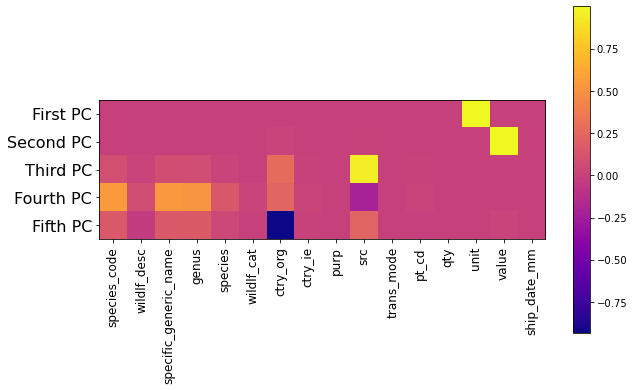

In [40]:
plot_pca(pca, feature_cols)

<AxesSubplot:>

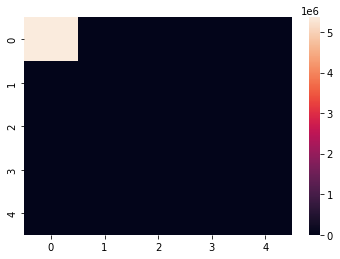

In [41]:
sns.heatmap(empirical_covariance(X_train_pca))

#### Archive - do not run 

In [ ]:
numerical_var = ['value', 'qty']
categorical_var = ['species_code', 'wildlf_desc', 'specific_generic_name', 'genus', 'species', 'wildlf_cat', 
                'ctry_org', 'ctry_ie','purp', 'src', 'trans_mode', 'pt_cd', 'unit']


ct_target = make_column_transformer(
    (TargetEncoder(), categorical_var),
    (StandardScaler(), numerical_var),
    remainder='passthrough')